In [1]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn

import seaborn as sns
from scipy.stats import norm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB




In [2]:
bank_data = pd.read_csv("bank_additional_full.csv")
bank_copy = bank_data.copy()

In [3]:
# Check missing values
bank_copy.isna().count()

age               41188
job               41188
marital           41188
education         41188
default           41188
housing           41188
loan              41188
contact           41188
month             41188
day_of_week       41188
duration          41188
campaign          41188
pdays             41188
previous          41188
poutcome          41188
emp.var.rate      41188
cons.price.idx    41188
cons.conf.idx     41188
euribor3m         41188
nr.employed       41188
y                 41188
dtype: int64

In [4]:
agecolumn = bank_copy['age'].copy()

# Protected group (young & old) == 0
for i in range(0,len(agecolumn)):
    if agecolumn[i] <= 75 and agecolumn[i] > 30:
        agecolumn[i] = 1
    else: 
        agecolumn[i] = 0
        
bank_copy['age'] = agecolumn

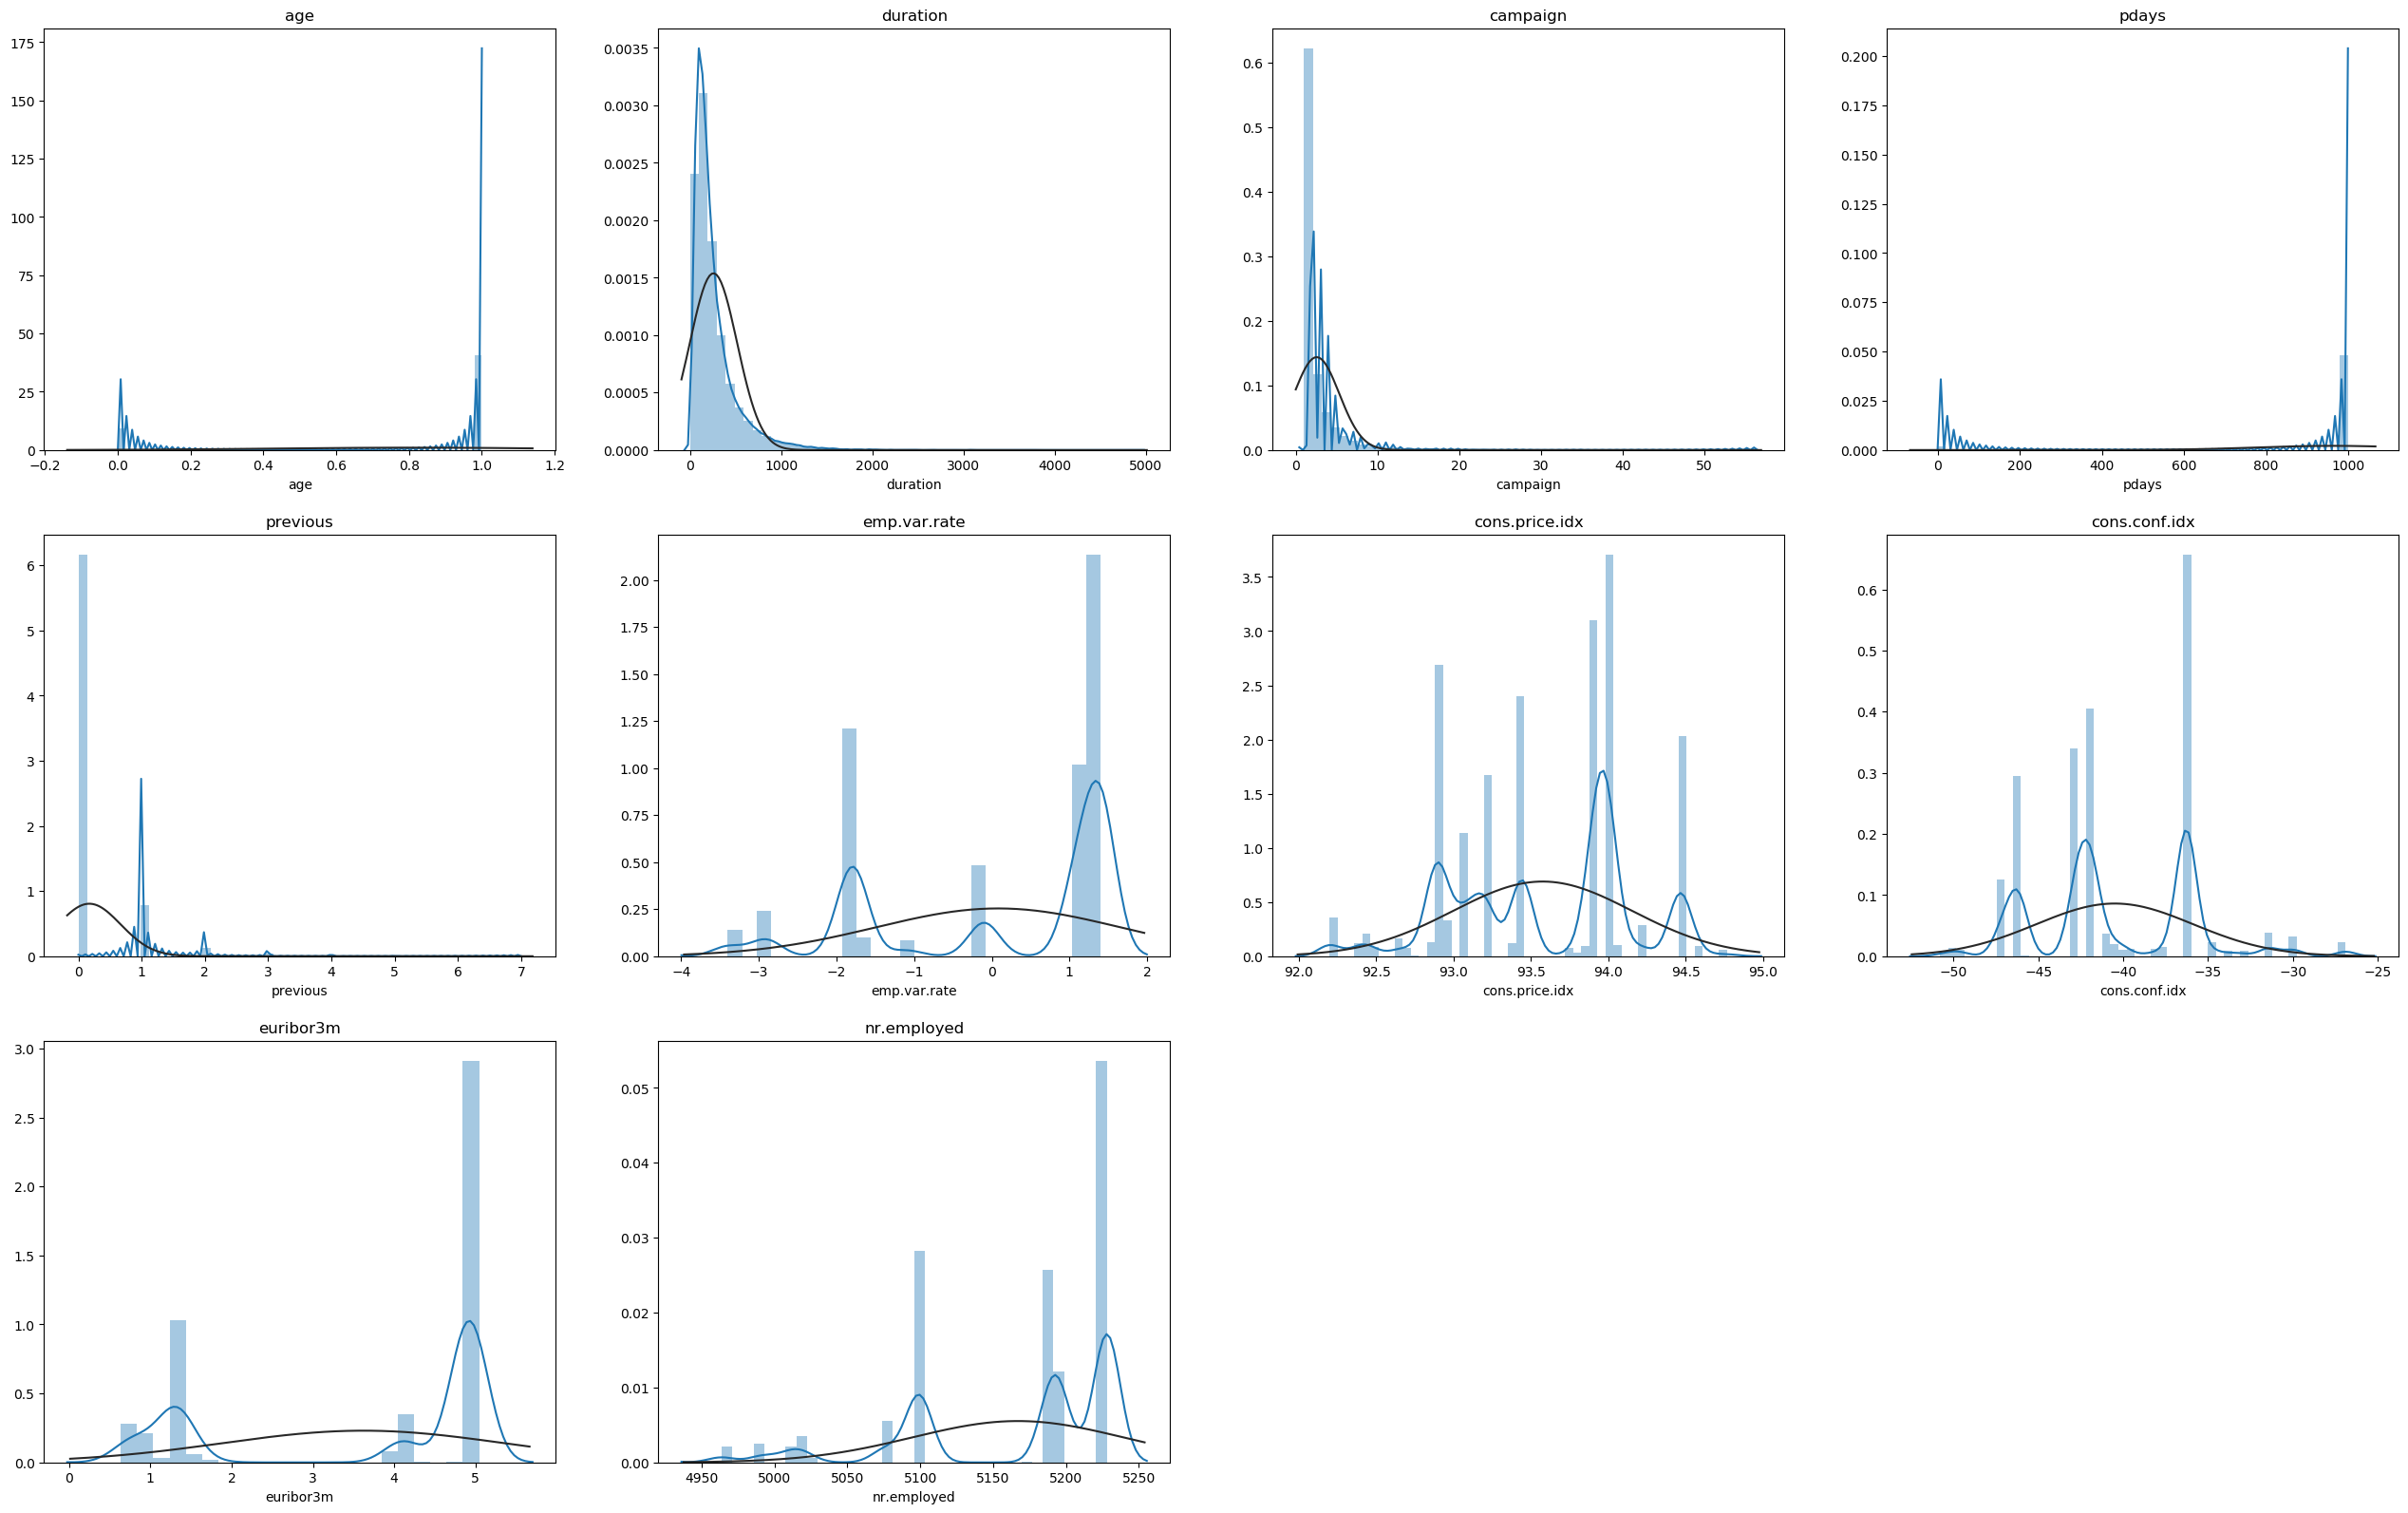

In [5]:
# Plots densities before I have taken log
ex = list(bank_copy.describe().columns)
plt.rcParams['figure.figsize'] = (32,20)
plt.rcParams['figure.dpi'] = 100
for i in range(len(ex)):
    x = ex[i]
    plt.subplot(3, 4, i+1) 
    sns.distplot(bank_copy[x] , fit = norm)
    (mu, sigma) = norm.fit(bank_copy[x])
    plt.title(x)

In [6]:
# One Hot Encoding columns
bank_copy = pd.get_dummies(bank_copy)

In [7]:
col_names = bank_copy.columns

scaler = MinMaxScaler() 
bank_copy = pd.DataFrame(scaler.fit_transform(bank_copy))
bank_copy.columns = col_names

bank_copy.rename(columns = {'y_yes':'outcome'}, inplace = True) 
del bank_copy['y_no']


In [8]:
default_correlation = pd.DataFrame(bank_copy.corr())['outcome']
default_correlation = list(default_correlation.sort_values(ascending = False)[abs(default_correlation) < 0.01].to_dict().keys())

bank_copy = bank_copy.drop(default_correlation, axis = 1)


In [9]:
bank_copy.groupby(['age','outcome']).count()

duration  campaign  pdays  previous  emp.var.rate  \
age outcome                                                      
0.0 0.0          6375      6375   6375      6375          6375   
    1.0          1253      1253   1253      1253          1253   
1.0 0.0         30173     30173  30173     30173         30173   
    1.0          3387      3387   3387      3387          3387   

             cons.price.idx  cons.conf.idx  euribor3m  nr.employed  \
age outcome                                                          
0.0 0.0                6375           6375       6375         6375   
    1.0                1253           1253       1253         1253   
1.0 0.0               30173          30173      30173        30173   
    1.0                3387           3387       3387         3387   

             job_admin.  ...  month_mar  month_may  month_nov  month_oct  \
age outcome              ...                                               
0.0 0.0            6375  ...       6375       6375       6375       6375   
    1.0            1253  ...       1253       1253       1253       1253   
1.0 0.0           30173  ...      30173      30173      30173      30173   
    1.0            3387  ...       3387       3387       3387       3387   

             month_sep  day_of_week_mon  day_of_week_thu  poutcome_failure  \
age outcome                                                                  
0.0 0.0           6375             6375             6375              6375   
    1.0           1253             1253             1253              1253   
1.0 0.0          30173            30173            30173             30173   
    1.0           3387             3387             3387              3387   

             poutcome_nonexistent  poutcome_success  
age outcome                                          
0.0 0.0                      6375              6375  
    1.0                      1253              1253  
1.0 0.0                     30173             30173  
    1.0                      3387              3387  

[4 rows x 43 columns]

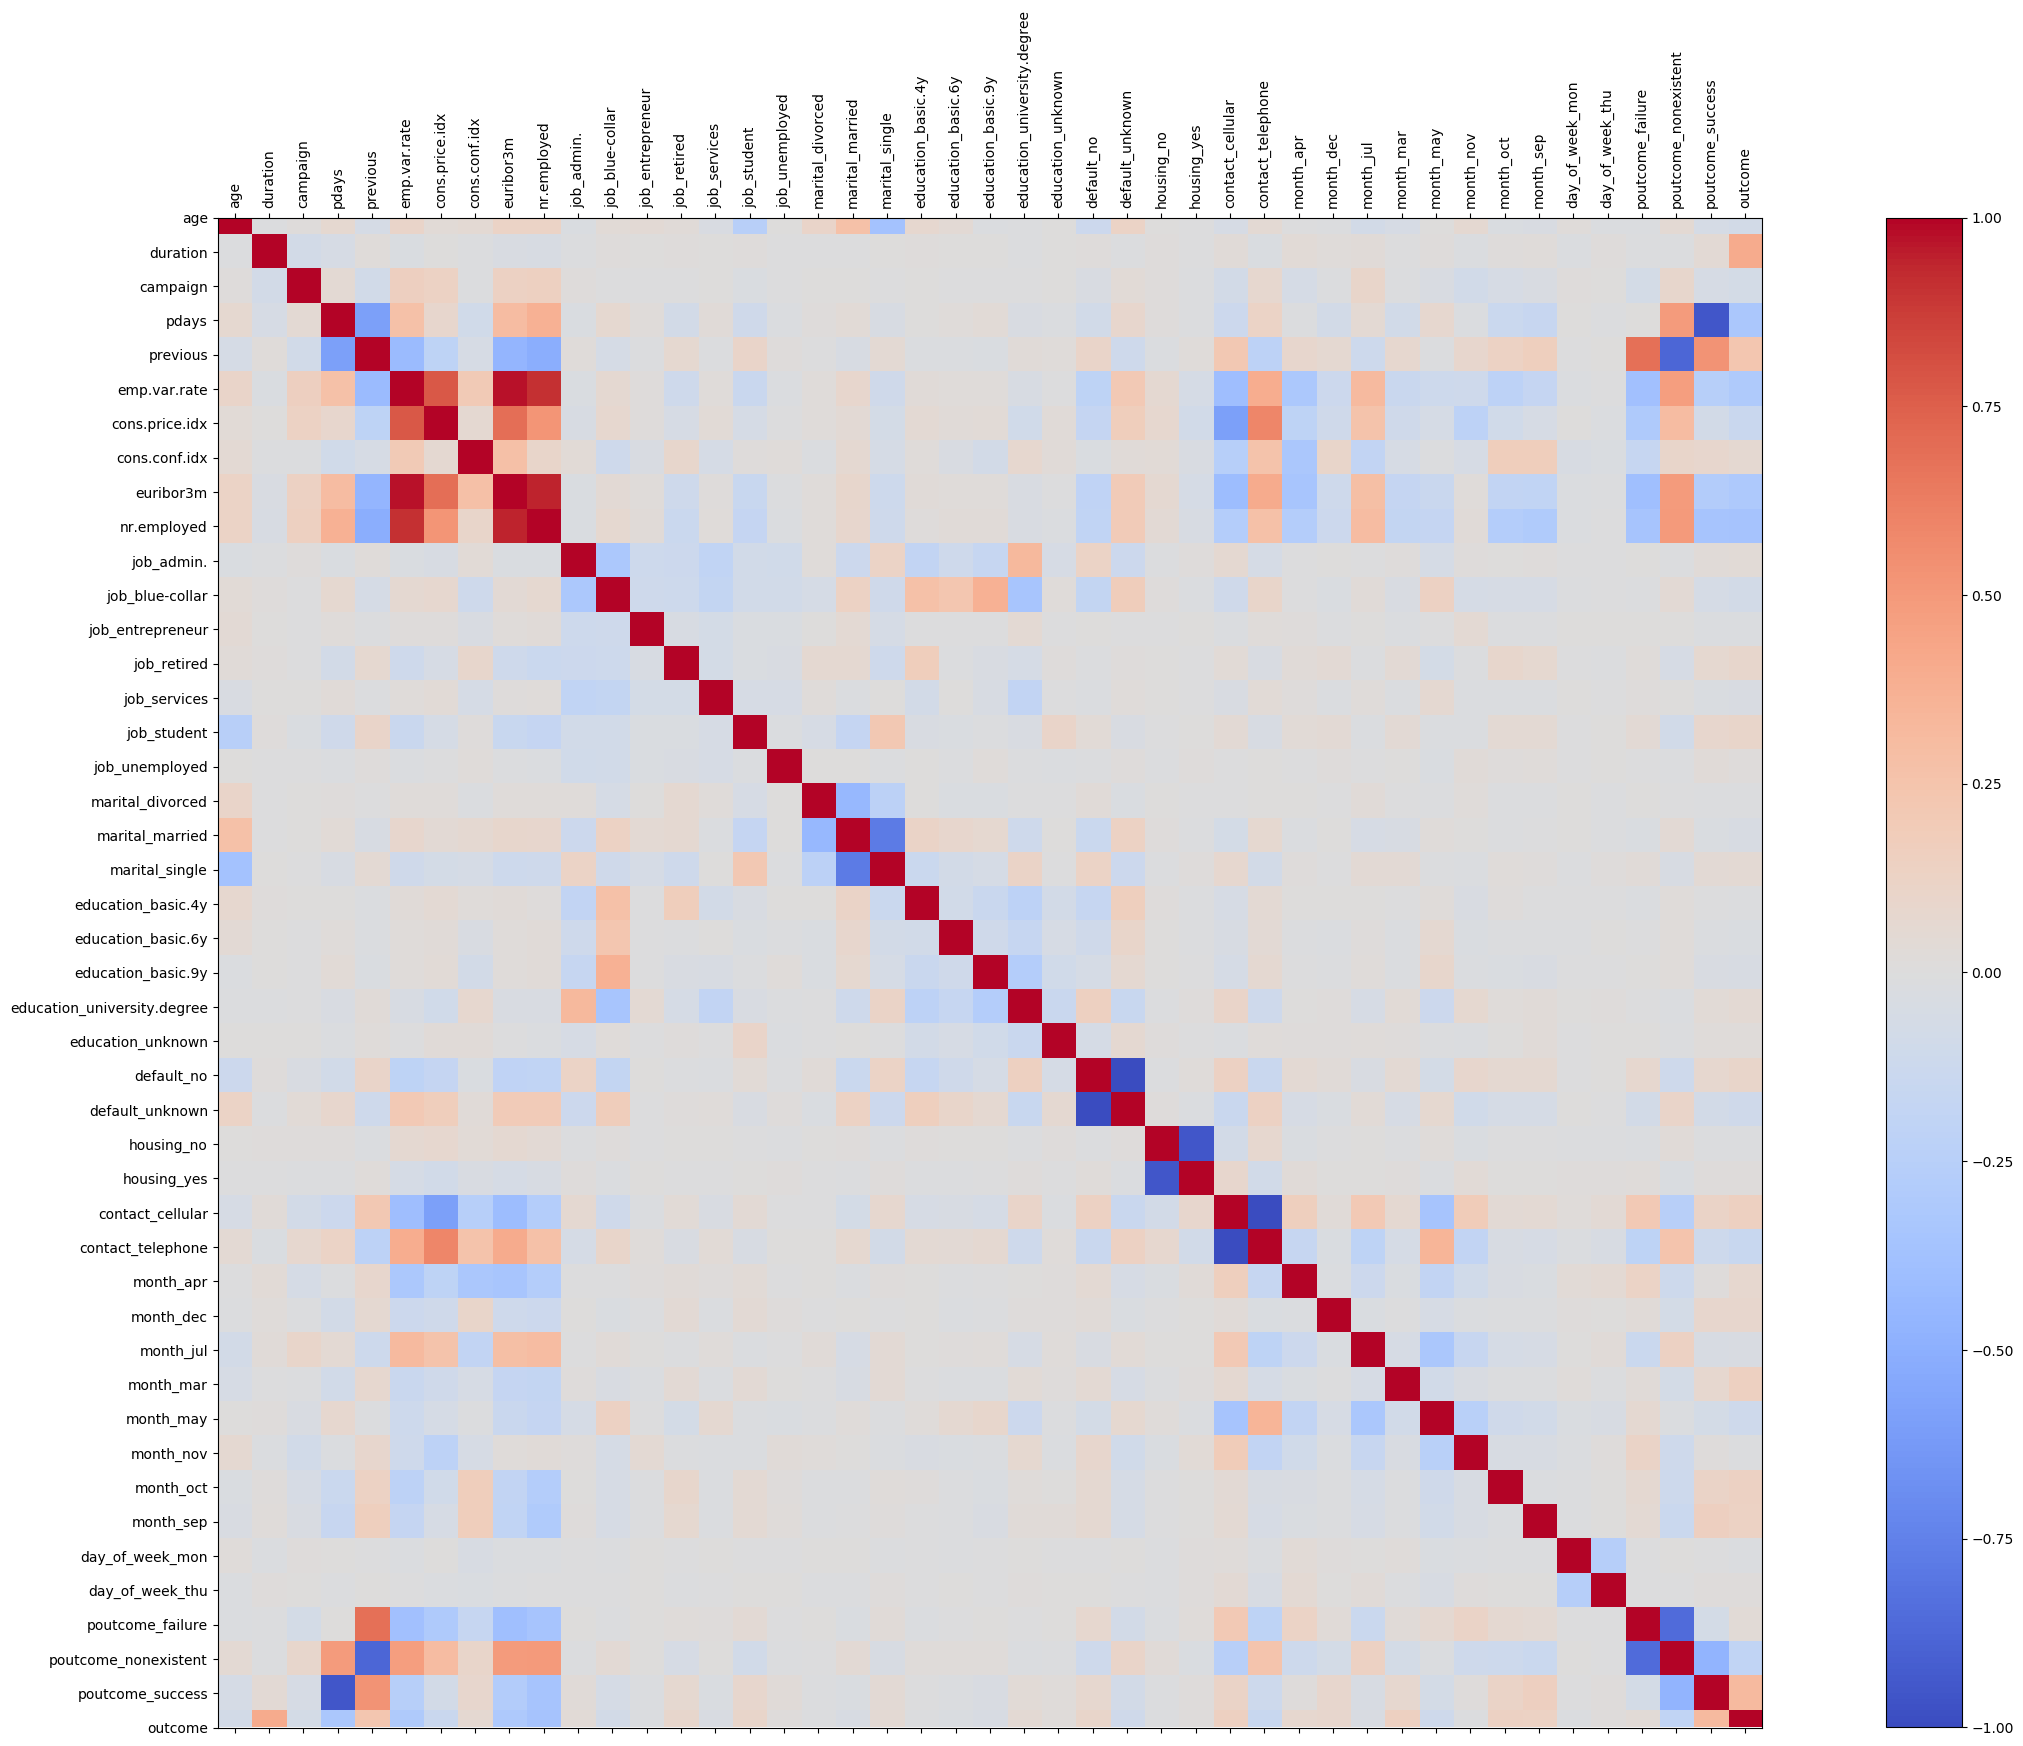

In [10]:
corr = bank_copy.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(bank_copy.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(bank_copy.columns)
ax.set_yticklabels(bank_copy.columns)
plt.show()

# Modify these columns due to dependency
bank_copy.rename(columns = {'housing_yes':'housing'}, inplace = True) 
del bank_copy['housing_no']
bank_copy.rename(columns = {'contact_cellular':'contact_mobile'}, inplace = True) 
del bank_copy['contact_telephone']
del bank_copy['default_unknown']
del bank_copy['emp.var.rate']
del bank_copy['euribor3m']


# Helper Functions

In [11]:
def fairness_check(list1, epsilon): 
    '''
        Checks if a list of numbers is within a range.
        To modify upper bound delete 'and x <= list1[0]*(1+epsilon)'
    '''
    c = 0 
    # traverse in the list1 
    for x in list1: 
        
        if x >= list1[0]*(1-epsilon) and x <= list1[0]*(1+epsilon): 
            
            c+= 1 
            
    if c == 2:
        return True 
    else:
        return False
    
def fairness_check_odds(list1, list2, epsilon): 
    '''
        Checks if a list of numbers is within a range
        modified for equalised odds with two conditions.
        To modify upper bound delete 'and x <= list1[0]*(1+epsilon)' and 
                                    'and y <= list2[0]*(1+epsilon)'
    '''
    c = 0 
    # traverse in the list1 
    for x in list1: 
        
        if x >= list1[0]*(1-epsilon) and x <= list1[0]*(1+epsilon): 
            
            c+= 1 
            
    d = 0 
    # traverse in the list2
    for y in list2: 
        
        if y>= list2[0]*(1-epsilon) and y <= list2[0]*(1+epsilon): 
            
            d+= 1 
            
    if c == 2 and d == 2:
        return True 
    else:
        return False

def p_rule_check(list1, p):
    """
        Check if the p_rule is satisfied
    """
    x = 0
    for i in list1:
        if i >= p:
            x += 1
    if x == 2:
        return True
    else:
        return False

def bank_stats(x,string,epsilon,p):
    
    
    """
    Splits dataset into male/female young(or old)/middle aged subsets in order
    to be able to get the confusion matrices for each of the protected attributes.
    
    Also prints checks for fairness definitions
    
    """
    
    confusion = pd.DataFrame(sklearn.metrics.confusion_matrix(x.outcome, x[string]))
    #confusion.columns = ['Positive', 'Negative']
    #confusion.index = ['Positive', 'Negative']
    
    print("% of correct prediction:", 
      round(sum(x.outcome == x[string])*100/len(x),2))
    print(confusion)
    print("")
    
    listy = ['unprotected', 'protected']
    df_dict = {}
    
    parity = []
    opportunity = []
    odds = []
    p_rule = []
    for df in listy:
        
        # Splitting results into age confusion matrices
        if 'unprotected' in df:
            df_dict[df + '_results'] = x[x['age'] == 1]
                
        else:
            df_dict[df + '_results'] = x[x['age'] == 0]

        # Easier to manually print metric rates
        
        
        confusion_matrix = pd.DataFrame(sklearn.metrics.confusion_matrix(df_dict[df + '_results'].outcome, df_dict[df + '_results'][string]))
        TPR = str(round(confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1]),3))
        FPR = str(round(confusion_matrix[0][1]/(confusion_matrix[1][1]+confusion_matrix[0][1]),3))
        FNR = str(round(confusion_matrix[1][0]/(confusion_matrix[0][0]+confusion_matrix[1][0]),3))
        TNR = str(round(confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0]),3))
        
        # Loop totaling the number of entries in a group (e.g. male unprotected + male protected etc.)
        total = 0
        for i in range(0,2):
            for k in range(0,2):
                total = total + confusion_matrix[i][k]
                
        positive = confusion_matrix[1][0]+confusion_matrix[1][1]
        negative = confusion_matrix[0][1]+confusion_matrix[0][0]
        
        parity.append(round((positive)/total,3))
        opportunity.append(round(pd.to_numeric(TPR),3))
        odds.append(round(pd.to_numeric(FPR),3))
        p_rule.append(positive)
        
        confusion_matrix.columns = ['Pred Negative', 'Pred Positive']
        confusion_matrix.index = ['True Negative', 'True Positive']
        
        print('The confusion matrix for ' + df + ' is:')
        print(confusion_matrix)
        print('')
        print('TPR: '+TPR+', FPR: '+FPR+', FNR: '+FNR+', TNR: '+TNR)
        print('')
        print('')
    
    p_rule = parity/parity[0]
    p_rule = [round(x,3) for x in p_rule]
    
    parity_difference = []
    opp_difference = []
    odd_difference = []
    
    for i in range(0,1):
        parity_difference.append(abs(parity[i+1]-parity[0]))
        opp_difference.append(abs(opportunity[i+1]-opportunity[0]))
        odd_difference.append(abs(odds[i+1]-odds[0]))

    
    parity_difference = np.mean(parity_difference)
    opp_difference = np.mean(opp_difference)
    odd_difference = np.mean(odd_difference)
    p_difference = round(p_rule[1]-0.8,3)

    
    print('The proportion of a given group being assigned to the positive group are :',parity)
    print('The boundaries for statistical parity are: ',round(parity[0]*(1-epsilon),3),round(parity[0]*(1+epsilon),3))
    print('Is statistical parity satisfied? ', fairness_check(parity, epsilon))
    print('Difference between assigned positive rates: ', round(parity_difference*100/parity[0],2))
    print('')
    print('The TPR rates are :',opportunity)
    print('The boundaries for equalised opportunity are: ',round(opportunity[0]*(1-epsilon),3),round(opportunity[0]*(1+epsilon),3))
    print('Is equalised opportunity satisfied? ', fairness_check(opportunity, epsilon))
    print('Difference between TPR: ', round(opp_difference*100/opportunity[0],2))
    print('')
    print('The TPR rates are :',opportunity)
    print('The FPR rates are :',odds)
    print('The boundaries for equalised odds are: ',round(opportunity[0]*(1-epsilon),3),round(opportunity[0]*(1+epsilon),3),
         ' (TPR) and: ', round(odds[0]*(1-epsilon),3),round(odds[0]*(1+epsilon),3), ' (FPR)')
    print('Is equalised odds satisfied? ', fairness_check_odds(opportunity, odds, epsilon))
    print('Average Difference: ', round((odd_difference*100/odds[0]+opp_difference*100/opportunity[0])/2,2)
    )
    print('')
    print('The p ratios are: ', p_rule)
    print('Is the p_rule satisfied? ', p_rule_check(p_rule, p))
    print('Average difference above: ', p_difference)
    print('')
    print('DI: ', round(parity[1]/parity[0],2))
    print('CV: ', round(1-(parity[0]-parity[1]),2))
        

# Original

In [12]:
# Splitting dataset
y = bank_copy['outcome']
x = bank_copy.drop('outcome',axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [13]:
# Creating new dataframe so I can store results
results = pd.DataFrame(y_test)
results['age'] = x_test['age']

In [14]:
x_train_copy = x_train.copy()
x_train_copy['outcome'] = y_train
x_train_copy.groupby(['age','outcome']).count()

duration  campaign  pdays  previous  cons.price.idx  \
age outcome                                                        
0.0 0.0          5190      5190   5190      5190            5190   
    1.0          1001      1001   1001      1001            1001   
1.0 0.0         24039     24039  24039     24039           24039   
    1.0          2720      2720   2720      2720            2720   

             cons.conf.idx  nr.employed  job_admin.  job_blue-collar  \
age outcome                                                            
0.0 0.0               5190         5190        5190             5190   
    1.0               1001         1001        1001             1001   
1.0 0.0              24039        24039       24039            24039   
    1.0               2720         2720        2720             2720   

             job_entrepreneur  ...  month_mar  month_may  month_nov  \
age outcome                    ...                                    
0.0 0.0                  5190  ...       5190       5190       5190   
    1.0                  1001  ...       1001       1001       1001   
1.0 0.0                 24039  ...      24039      24039      24039   
    1.0                  2720  ...       2720       2720       2720   

             month_oct  month_sep  day_of_week_mon  day_of_week_thu  \
age outcome                                                           
0.0 0.0           5190       5190             5190             5190   
    1.0           1001       1001             1001             1001   
1.0 0.0          24039      24039            24039            24039   
    1.0           2720       2720             2720             2720   

             poutcome_failure  poutcome_nonexistent  poutcome_success  
age outcome                                                            
0.0 0.0                  5190                  5190              5190  
    1.0                  1001                  1001              1001  
1.0 0.0                 24039                 24039             24039  
    1.0                  2720                  2720              2720  

[4 rows x 38 columns]

## Logistic

In [15]:
# Initiate logistic regression method
multi_class = sklearn.linear_model.LogisticRegression().fit(x_train,y_train)
results['logistic'] = multi_class.predict(x_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
# Stats for logistic method
bank_stats(results,'logistic',0.1,0.8)

% of correct prediction: 91.42
      0    1
0  7140  179
1   528  391

The confusion matrix for unprotected is:
               Pred Negative  Pred Positive
True Negative           6014            120
True Positive            408            259

TPR: 0.388, FPR: 0.612, FNR: 0.02, TNR: 0.98


The confusion matrix for protected is:
               Pred Negative  Pred Positive
True Negative           1126             59
True Positive            120            132

TPR: 0.524, FPR: 0.476, FNR: 0.05, TNR: 0.95


The proportion of a given group being assigned to the positive group are : [0.056, 0.133]
The boundaries for statistical parity are:  0.05 0.062
Is statistical parity satisfied?  False
Difference between assigned positive rates:  137.5

The TPR rates are : [0.388, 0.524]
The boundaries for equalised opportunity are:  0.349 0.427
Is equalised opportunity satisfied?  False
Difference between TPR:  35.05

The TPR rates are : [0.388, 0.524]
The FPR rates are : [0.612, 0.476]
The boundarie

## SVC

In [17]:
# Initiate decision tree method
multi_class = SVC(kernel='linear').fit(x_train,y_train)
results['SVC'] = multi_class.predict(x_test)

In [18]:
# Stats for SVC method
bank_stats(results,'SVC',0.1,0.8)

% of correct prediction: 90.25
      0    1
0  7175  144
1   659  260

The confusion matrix for unprotected is:
               Pred Negative  Pred Positive
True Negative           6028            106
True Positive            492            175

TPR: 0.262, FPR: 0.738, FNR: 0.017, TNR: 0.983


The confusion matrix for protected is:
               Pred Negative  Pred Positive
True Negative           1147             38
True Positive            167             85

TPR: 0.337, FPR: 0.663, FNR: 0.032, TNR: 0.968


The proportion of a given group being assigned to the positive group are : [0.041, 0.086]
The boundaries for statistical parity are:  0.037 0.045
Is statistical parity satisfied?  False
Difference between assigned positive rates:  109.76

The TPR rates are : [0.262, 0.337]
The boundaries for equalised opportunity are:  0.236 0.288
Is equalised opportunity satisfied?  False
Difference between TPR:  28.63

The TPR rates are : [0.262, 0.337]
The FPR rates are : [0.738, 0.663]
The bou

## RF

In [19]:
# Initiate decision tree method
multi_class = RandomForestClassifier(n_estimators = 2500).fit(x_train,y_train)
results['random_forest'] = multi_class.predict(x_test)

In [20]:
# Stats for RF method
bank_stats(results,'random_forest',0.1,0.8)

% of correct prediction: 91.7
      0    1
0  7053  266
1   418  501

The confusion matrix for unprotected is:
               Pred Negative  Pred Positive
True Negative           5941            193
True Positive            321            346

TPR: 0.519, FPR: 0.481, FNR: 0.031, TNR: 0.969


The confusion matrix for protected is:
               Pred Negative  Pred Positive
True Negative           1112             73
True Positive             97            155

TPR: 0.615, FPR: 0.385, FNR: 0.062, TNR: 0.938


The proportion of a given group being assigned to the positive group are : [0.079, 0.159]
The boundaries for statistical parity are:  0.071 0.087
Is statistical parity satisfied?  False
Difference between assigned positive rates:  101.27

The TPR rates are : [0.519, 0.615]
The boundaries for equalised opportunity are:  0.467 0.571
Is equalised opportunity satisfied?  False
Difference between TPR:  18.5

The TPR rates are : [0.519, 0.615]
The FPR rates are : [0.481, 0.385]
The bound

## NB

In [21]:
# Initiate decision tree method
multi_class = GaussianNB().fit(x_train,y_train)
results['NB'] = multi_class.predict(x_test)

In [22]:
# Stats for NB method
bank_stats(results,'NB',0.1,0.8)

% of correct prediction: 87.52
      0    1
0  6764  555
1   473  446

The confusion matrix for unprotected is:
               Pred Negative  Pred Positive
True Negative           5771            363
True Positive            381            286

TPR: 0.429, FPR: 0.571, FNR: 0.059, TNR: 0.941


The confusion matrix for protected is:
               Pred Negative  Pred Positive
True Negative            993            192
True Positive             92            160

TPR: 0.635, FPR: 0.365, FNR: 0.162, TNR: 0.838


The proportion of a given group being assigned to the positive group are : [0.095, 0.245]
The boundaries for statistical parity are:  0.086 0.105
Is statistical parity satisfied?  False
Difference between assigned positive rates:  157.89

The TPR rates are : [0.429, 0.635]
The boundaries for equalised opportunity are:  0.386 0.472
Is equalised opportunity satisfied?  False
Difference between TPR:  48.02

The TPR rates are : [0.429, 0.635]
The FPR rates are : [0.571, 0.365]
The bou

# Suppression

In [23]:
# Most correlated attributes with the sensitive attributes
age_correlation = pd.DataFrame(bank_copy.corr())['age']

print(pd.DataFrame(age_correlation.sort_values(ascending = False)[abs(age_correlation) > 0.1]))

                       age
age               1.000000
marital_married   0.265659
nr.employed       0.123956
marital_divorced  0.106067
default_no       -0.122359
job_student      -0.248772
marital_single   -0.363613


In [24]:
# New dataset
bank_suppression = bank_copy.copy()

# Finding most correlated attributes with age & gender
age_correlation = pd.DataFrame(bank_copy.corr())['age']
age_correlated = age_correlation.sort_values(ascending = False)[abs(age_correlation) > 0.1].to_dict()

# Getting dictionary keys as a list
age_correlated_items = list(age_correlated.keys())


In [25]:
# Creating new dataframe so I can store results
results_suppression = pd.DataFrame(y_test)
results_suppression['age'] = x_test['age']

# Deleting most correlated attributes as well as sensitive attributes
x_train_suppression = x_train.drop(age_correlated_items, axis = 1)
x_test_suppression = x_test.drop(age_correlated_items, axis = 1)
y_train_suppression = y_train.copy()
y_test_suppression = y_test.copy()

## Logistic

In [26]:
# Initiate logistic regression method
multi_class = sklearn.linear_model.LogisticRegression().fit(x_train_suppression,y_train_suppression)
results_suppression['logistic'] = multi_class.predict(x_test_suppression)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [27]:
# Stats for logistic method
bank_stats(results_suppression,'logistic',0.1,0.8)

% of correct prediction: 91.1
      0    1
0  7158  161
1   572  347

The confusion matrix for unprotected is:
               Pred Negative  Pred Positive
True Negative           6005            129
True Positive            426            241

TPR: 0.361, FPR: 0.639, FNR: 0.021, TNR: 0.979


The confusion matrix for protected is:
               Pred Negative  Pred Positive
True Negative           1153             32
True Positive            146            106

TPR: 0.421, FPR: 0.579, FNR: 0.027, TNR: 0.973


The proportion of a given group being assigned to the positive group are : [0.054, 0.096]
The boundaries for statistical parity are:  0.049 0.059
Is statistical parity satisfied?  False
Difference between assigned positive rates:  77.78

The TPR rates are : [0.361, 0.421]
The boundaries for equalised opportunity are:  0.325 0.397
Is equalised opportunity satisfied?  False
Difference between TPR:  16.62

The TPR rates are : [0.361, 0.421]
The FPR rates are : [0.639, 0.579]
The bound

## SVC

In [28]:
# Initiate SVC method
multi_class = SVC(kernel='linear').fit(x_train_suppression,y_train_suppression)
results_suppression['SVC'] = multi_class.predict(x_test_suppression)

In [29]:
# Stats for SVC method
bank_stats(results_suppression,'SVC',0.1,0.8)

% of correct prediction: 89.75
      0    1
0  7205  114
1   730  189

The confusion matrix for unprotected is:
               Pred Negative  Pred Positive
True Negative           6054             80
True Positive            543            124

TPR: 0.186, FPR: 0.814, FNR: 0.013, TNR: 0.987


The confusion matrix for protected is:
               Pred Negative  Pred Positive
True Negative           1151             34
True Positive            187             65

TPR: 0.258, FPR: 0.742, FNR: 0.029, TNR: 0.971


The proportion of a given group being assigned to the positive group are : [0.03, 0.069]
The boundaries for statistical parity are:  0.027 0.033
Is statistical parity satisfied?  False
Difference between assigned positive rates:  130.0

The TPR rates are : [0.186, 0.258]
The boundaries for equalised opportunity are:  0.167 0.205
Is equalised opportunity satisfied?  False
Difference between TPR:  38.71

The TPR rates are : [0.186, 0.258]
The FPR rates are : [0.814, 0.742]
The bound

## RF

In [ ]:
# Initiate decision tree method
multi_class = RandomForestClassifier(n_estimators = 2500).fit(x_train_suppression,y_train_suppression)
results_suppression['random_forest'] = multi_class.predict(x_test_suppression)

In [ ]:
# Stats for RF method
bank_stats(results_suppression,'random_forest',0.1,0.8)

## NB

In [ ]:
# Initiate decision tree method
multi_class = GaussianNB().fit(x_train_suppression,y_train_suppression)
results_suppression['NB'] = multi_class.predict(x_test_suppression)

In [ ]:
# Stats for NB method
bank_stats(results_suppression,'NB',0.1,0.8)

# Reweighing

In [ ]:
bank_weighted = bank_copy.copy()

weightings = [0] * len(bank_weighted)

for i in range(0,len(bank_weighted)):
    # Protected
    if bank_weighted['age'][i] == 1:
        if bank_weighted['outcome'][i] == 1: 
            # Positive Privileged
            weightings[i] = 1.111
        else:
            # Negative Privileged
            weightings[i] = 0.987
    # Unprotected
    else:
        if bank_weighted['outcome'][i] == 1: 
            # Positive Unprivileged
            weightings[i] = 0.698
        else:
            # Negative Unprivileged
            weightings[i] = 1.058

bank_weighted['weights'] = weightings

In [ ]:
# Splitting dataset
y = bank_weighted['outcome']
x = bank_weighted.drop(['outcome'],axis = 1)
x_train_weighted, x_test_weighted, y_train_weighted, y_test_weighted = train_test_split(x, y, test_size = 0.2, random_state = 0)

training_weights = x_train_weighted['weights']
x_train_weighted = x_train_weighted.drop(['weights'], axis = 1)
x_test_weighted = x_test_weighted.drop(['weights'], axis = 1)

# Creating new dataframe so I can store results
results_weighted = pd.DataFrame(y_test_weighted)
results_weighted['age'] = x_test['age']

## Logistic

In [ ]:
# Initiate logistic regression method
multi_class = sklearn.linear_model.LogisticRegression().fit(x_train_weighted,y_train_weighted, sample_weight = training_weights)
results_weighted['logistic'] = multi_class.predict(x_test_weighted)

In [ ]:
# Stats for logistic method
bank_stats(results_weighted,'logistic',0.1,0.8)

## SVC

In [ ]:
# Initiate decision tree method
multi_class = SVC(kernel='linear').fit(x_train_weighted,y_train_weighted, sample_weight = training_weights)
results_weighted['SVC'] = multi_class.predict(x_test_weighted)

In [ ]:
# Stats for SVC method
bank_stats(results_weighted,'SVC',0.1,0.8)

## RF

In [ ]:
# Initiate decision tree method
multi_class = RandomForestClassifier(n_estimators = 2500).fit(x_train_weighted,y_train_weighted, sample_weight = training_weights)
results_weighted['random_forest'] = multi_class.predict(x_test_weighted)

In [ ]:
# Stats for RF method
bank_stats(results_weighted,'random_forest',0.1,0.8)

## NB

In [ ]:
# Initiate decision tree method
multi_class = GaussianNB().fit(x_train_weighted,y_train_weighted, sample_weight = training_weights)
results_weighted['NB'] = multi_class.predict(x_test_weighted)

In [ ]:
# Stats for NB method
bank_stats(results_weighted,'NB',0.1,0.8)

# Both

In [ ]:
# Splitting dataset
y = bank_weighted['outcome']
x = bank_weighted.drop(['outcome'],axis = 1)
x_train_both, x_test_both, y_train_both, y_test_both = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Creating new dataframe so I can store results
results_both = pd.DataFrame(y_test_both)
results_both['age'] = x_test_both['age']

# Extract weights then delete column
training_weights = x_train_both['weights']

age_correlated_items = age_correlated_items + ['weights']
x_train_both = x_train_both.drop(age_correlated_items, axis = 1)
x_test_both = x_test_both.drop(age_correlated_items , axis = 1)




## Logistic

In [ ]:
# Initiate logistic regression method
multi_class = sklearn.linear_model.LogisticRegression().fit(x_train_both,y_train_both, sample_weight = training_weights)
results_both['logistic'] = multi_class.predict(x_test_both)



In [ ]:
# Stats for logistic method
bank_stats(results_both,'logistic',0.1,0.8)

## SVC

In [ ]:
# Initiate decision tree method
multi_class = SVC(kernel='linear').fit(x_train_both,y_train_both, sample_weight = training_weights)
results_both['SVC'] = multi_class.predict(x_test_both)

In [ ]:
# Stats for SVC method
bank_stats(results_both,'SVC',0.1,0.8)

## RF

In [ ]:
# Initiate decision tree method
multi_class = RandomForestClassifier(n_estimators = 2500).fit(x_train_both,y_train_both, sample_weight = training_weights)
results_both['random_forest'] = multi_class.predict(x_test_both)

In [ ]:
# Stats for RF method
bank_stats(results_both,'random_forest',0.1,0.8)

## NB

In [ ]:
# Initiate decision tree method
multi_class = GaussianNB().fit(x_train_both,y_train_both, sample_weight = training_weights)
results_both['NB'] = multi_class.predict(x_test_both)

In [ ]:
# Stats for NB method
bank_stats(results_both,'NB',0.1,0.8)